In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_style('white')

## Selecting only closed loans

In [2]:
# 887,379 loans in total
loans = pd.read_csv('../data/loan.csv')
loans['grade'] = loans['grade'].astype('category', ordered=True)
loans['last_pymnt_d'] = pd.to_datetime(loans['last_pymnt_d'])#.dt.strftime("%Y-%m-%d")
loans.shape

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(887379, 74)

In [3]:
loans['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'], dtype=object)

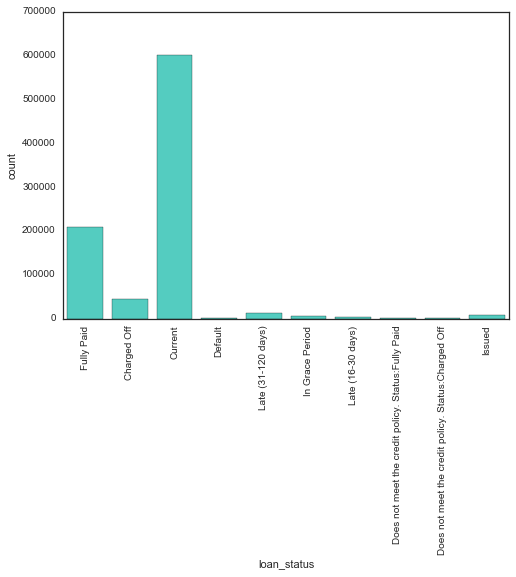

In [4]:
# most loans are current
sns.countplot(loans['loan_status'], color='turquoise')
plt.xticks(rotation=90)
plt.savefig('../figures/barplot_loan_statusses.jpg', bbox_inches='tight')

In [5]:
# exclude current loans leaves 256,939 (about 30%)
closed_status = ['Fully Paid', 'Charged Off',
              'Does not meet the credit policy. Status:Fully Paid',
              'Does not meet the credit policy. Status:Charged Off']
closed_loans = loans[loans['loan_status'].isin(closed_status)]
closed_loans.shape

(255720, 74)

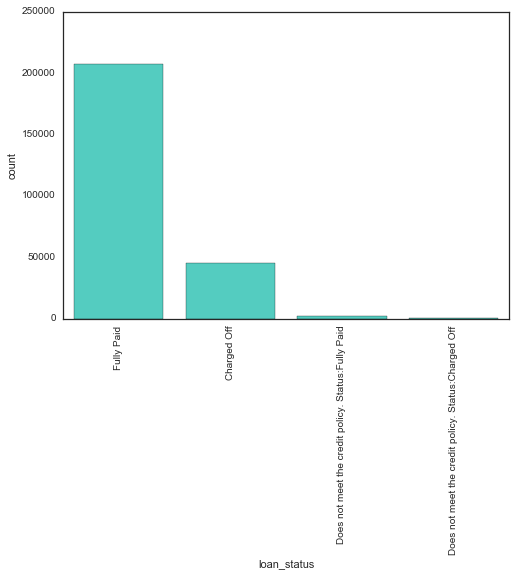

In [6]:
sns.countplot(closed_loans['loan_status'], color='turquoise')
plt.xticks(rotation=90)
plt.savefig('../figures/barplot_loan_statusses_closed.jpg', bbox_inches='tight')

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(array([0, 1]), <a list of 2 Text xticklabel objects>)

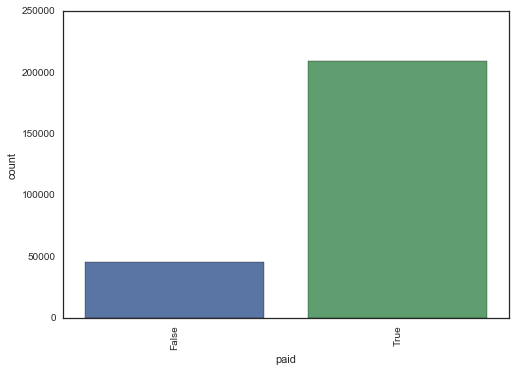

In [7]:
# two categories: paid/unpaid
paid_status = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
closed_loans['paid'] = [True if loan in paid_status else False for loan in closed_loans['loan_status']]
sns.countplot(closed_loans['paid'])
plt.xticks(rotation=90)

## Investigating closed loans

#### features summary

Total loans: 256,939
Total features: 74

Loan
- id: loan
- loan_amnt: 1914 times is loan amount bigger than funded amount
- funded_amnt
- funded_amnt_inv 
- term: 36 or 60 months
- int_rate: interest rates
- installment: height monthly pay
- grade: A-G, A low risk, G high risk
- sub_grade
- issue_d: month-year loan was funded
- loan_status
- pymnt_plan: n/y
- url
- desc: description provided by borrower
- purpose: 'credit_card', 'car', 'small_business', 'other', 'wedding', 'debt_consolidation', 'home_improvement', 'major_purchase', 'medical', 'moving', 'vacation', 'house', 'renewable_energy','educational'
- title: provided by borrower
- initial_list_status: w/f (what is this?)
- out_prncp: outstanding prinicipal --> still >0 in fully paid?!
- out_prncp_inv
- total_pymnt
- total_pymnt_inv
- total_rec_prncp
- total_rec_int: total recieved interest
- total_rec_late_fee
- recoveries: post charged off gross recovery
- collection_recovery_fee: post charged off collection fee
- last_pymnt_d
- last_pymnt_amnt
- next_pymnt_d
- collections_12_mths_ex_med: almost all 0
- policy_code: 1 publicly available, 2 not
- application_type (only 1 JOINT, rest INDIVIDUAL)


Borrower
- emp_title
- emp_length: 0-10 (10 stands for >=10)
- home_ownership: 'RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'
- member_id: person
- annual_inc (stated by borrower)
- verification_status: 'Verified', 'Source Verified', 'Not Verified' (income verified by LC?)
- zip_code
- addr_state
- dti: debt to income (without mortgage)
- delinq_2yrs: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- mths_since_last_delinq
- mths_since_last_record
- pub_rec
- earliest_cr_line
- inq_last_6mths 
- open_acc (nr of open credit lines)
- total_acc	(nr of total credit lines in credit file)
- revol_bal
- last_credit_pull_d
- mths_since_last_major_derog: Months since most recent 90-day or worse rating
- acc_now_delinq: The number of accounts on which the borrower is now delinquent.
- tot_coll_amt: Total collection amounts ever owed
- tot_cur_bal: Total current balance of all accounts
- open_acc_6m: Number of open trades in last 6 months
- open_il_6m: Number of currently active installment trades
- open_il_12m: Number of installment accounts opened in past 12 months
- open_il_24m
- mths_since_rcnt_il: Months since most recent installment accounts opened
- total_bal_il: Total current balance of all installment accounts
- il_util: Ratio of total current balance to high credit/credit limit on all install acct
- open_rv_12m: Number of revolving trades opened in past 12 months
- open_rv_24m
- max_bal_bc: Maximum current balance owed on all revolving accounts
- all_util: Balance to credit limit on all trades
- total_rev_hi_lim: Total revolving high credit/credit limit
- inq_fi: Number of personal finance inquiries
- total_cu_tl: Number of finance trades
- inq_last_12m: Number of credit inquiries in past 12 months

Two borrowers (only in 1 case)
- annual_inc_joint
- dti_joint
- verification_status_joint

#### Difference between default and charged off

In general, a note goes into Default status when it is 121 or more days past due.  When a note is in Default status, Charge Off occurs no later than 150 days past due (i.e. No later than 30 days after the Default status is reached) when there is no reasonable expectation of sufficient payment to prevent the charge off.  However, bankruptcies may be charged off earlier based on date of bankruptcy notification.

--> so default is not closed yet (so threw that one out).


In [8]:
# 1914 loans amounts bigger than funded amount
sum(closed_loans['loan_amnt'] != closed_loans['funded_amnt'])

1914

In [9]:
# nr of null values per feature
nr_nulls = closed_loans.isnull().apply(sum, 0)
nr_nulls = nr_nulls[nr_nulls != 0]
ratio_missing = nr_nulls.sort_values(ascending=False) / 255720
ratio_missing.to_csv('../data/missing_ratio.txt', sep='\t')
ratio_missing


dti_joint                      0.999996
annual_inc_joint               0.999996
verification_status_joint      0.999996
il_util                        0.999507
mths_since_rcnt_il             0.999453
total_cu_tl                    0.999437
open_acc_6m                    0.999437
open_il_6m                     0.999437
open_il_12m                    0.999437
open_il_24m                    0.999437
inq_last_12m                   0.999437
total_bal_il                   0.999437
open_rv_12m                    0.999437
open_rv_24m                    0.999437
max_bal_bc                     0.999437
all_util                       0.999437
inq_fi                         0.999437
next_pymnt_d                   0.989250
mths_since_last_record         0.873072
mths_since_last_major_derog    0.814074
desc                           0.645147
mths_since_last_delinq         0.555369
tot_cur_bal                    0.259882
tot_coll_amt                   0.259882
total_rev_hi_lim               0.259882


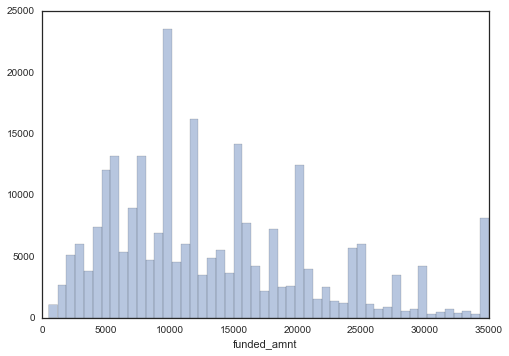

In [10]:
sns.distplot(closed_loans['funded_amnt'], kde=False, bins=50)
plt.savefig('../figures/funded_amount.jpg')

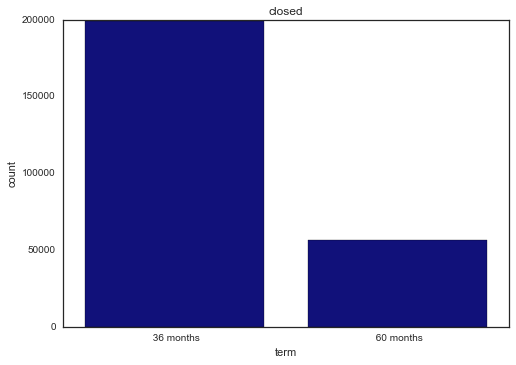

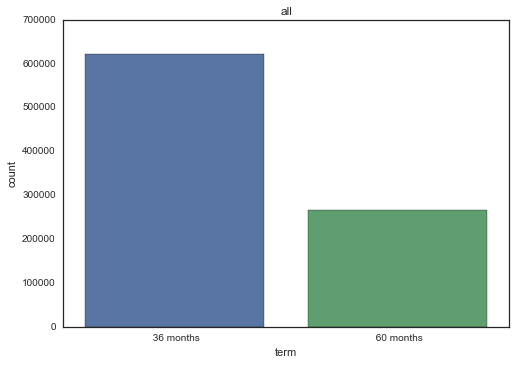

In [11]:
# closed loans about 20% are 60 months
# all loans lot of missing data, rest 30% are 60 months
sns.countplot(closed_loans['term'], color='darkblue')
plt.title('closed')
plt.savefig('../figures/term_closed.jpg')
plt.show()
sns.countplot(loans['term'])
plt.title('all')

## TODO: interest questions

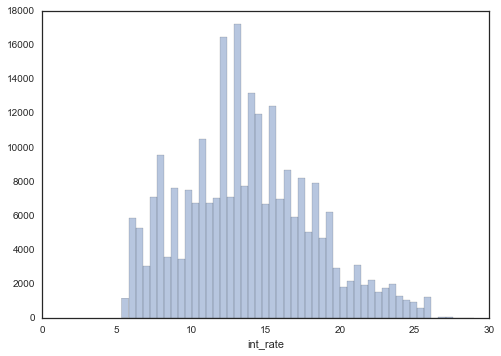

In [12]:
# higher interest rate more interesting for lenders
# higher grade gets higher interest rate (more risk)
# does it default more often?
# do you get richer from investing in grade A-C (less default?) or from D-G (more interest)?
fig = sns.distplot(closed_loans['int_rate'], kde=False, bins=50)
fig.set(xlim=(0, None))
plt.savefig('../figures/int_rates.jpg')

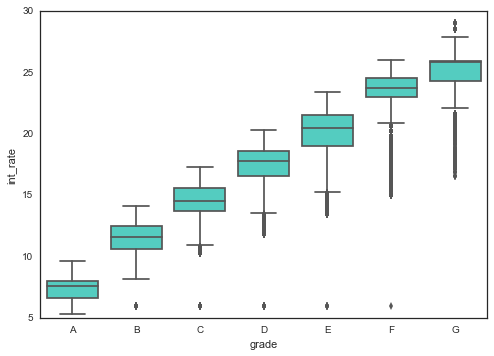

In [13]:
sns.boxplot(data=closed_loans, x='grade', y='int_rate', color='turquoise')
plt.savefig('../figures/boxplots_intrate_grade.jpg')

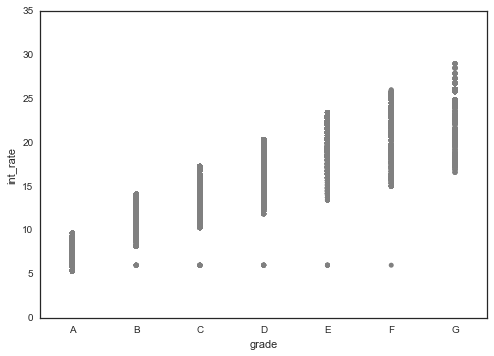

In [14]:
sns.stripplot(data=closed_loans, x='grade', y='int_rate', color='gray')

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


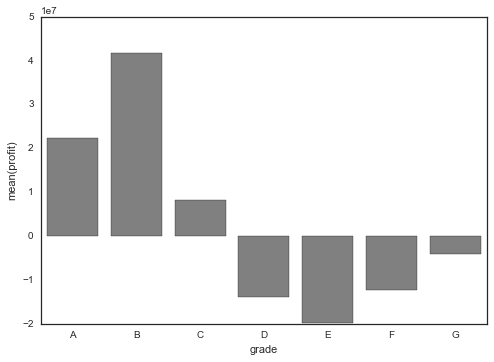

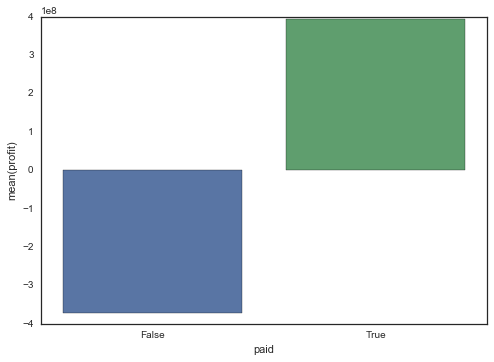

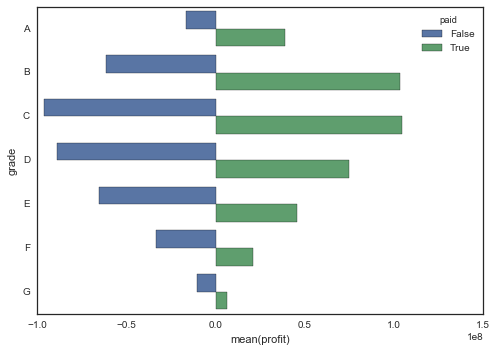

In [15]:
# closed_loans['collection_recovery_fee']
closed_loans['profit'] = (closed_loans['total_rec_int'] + closed_loans['total_rec_prncp'] 
                          + closed_loans['total_rec_late_fee'] + closed_loans['recoveries']) - closed_loans['funded_amnt'] 
profits = closed_loans.groupby('grade')['profit'].sum()
sns.barplot(data=profits.reset_index(), x='grade', y='profit', color='gray')
plt.savefig('../figures/profit_grades.jpg')
plt.show()
profits = closed_loans.groupby('paid')['profit'].sum()
sns.barplot(data=profits.reset_index(), x='paid', y='profit')
plt.show()
profits = closed_loans.groupby(['grade', 'paid'])['profit'].sum()
sns.barplot(data=profits.reset_index(), x='profit', y='grade', hue='paid', orient='h')
plt.savefig('../figures/profit_grades_paid.jpg')
plt.show()

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


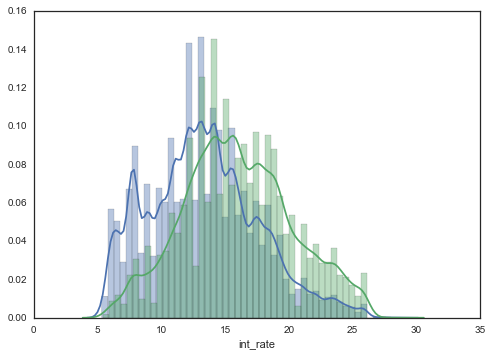

In [16]:
# Sort off normally distributed --> statistically test whether means are different?
sns.distplot(closed_loans[closed_loans['paid']==True]['int_rate'])
sns.distplot(closed_loans[closed_loans['paid']==False]['int_rate'])
plt.savefig('../figures/int_rate_paid.jpg')

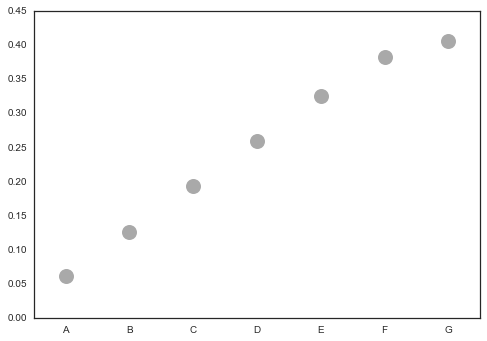

In [17]:
grade_paid = closed_loans.groupby(['grade', 'paid'])['id'].count()
risk_grades = dict.fromkeys(closed_loans['grade'].unique())
for g in risk_grades.keys():
    risk_grades[g] = grade_paid.loc[(g, False)] / (grade_paid.loc[(g, False)] + grade_paid.loc[(g, True)])
risk_grades = pd.DataFrame(risk_grades, index=['proportion_unpaid_loans'])    
sns.stripplot(data=risk_grades, color='darkgray', size=15)
plt.savefig('../figures/proportion_grades.jpg')

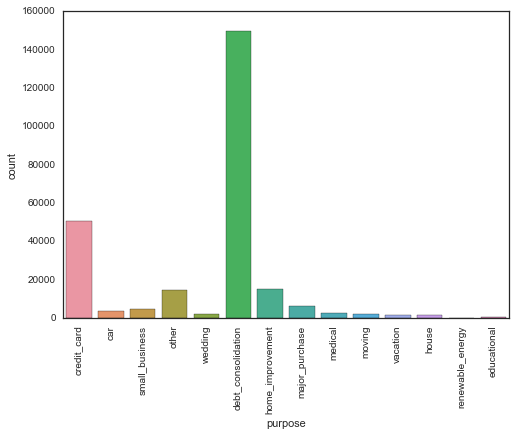

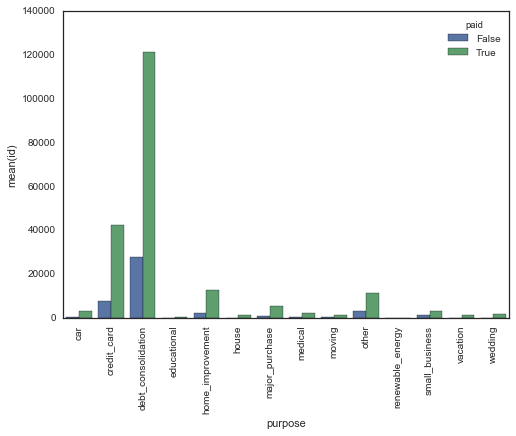

In [18]:
# does the purpose matter for the chance of charged off?
sns.countplot(closed_loans['purpose'], color='turquoise')
plt.xticks(rotation=90)
plt.show()
purpose_paid = closed_loans.groupby(['purpose', 'paid'])['id'].count()
sns.barplot(data=pd.DataFrame(purpose_paid).reset_index(), x='purpose', y='id', hue='paid')
plt.xticks(rotation=90)
plt.savefig('../figures/purposes.jpg', bbox_inches='tight')

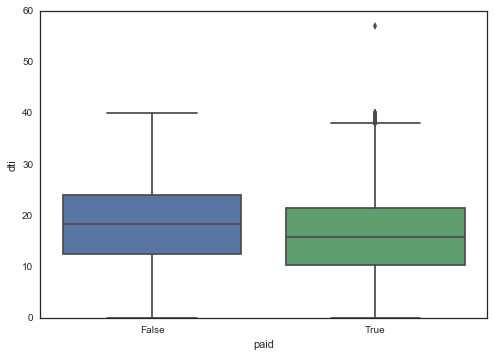

In [19]:
# debt to income
sns.boxplot(data=closed_loans, x='paid', y='dti')
plt.savefig('../figures/dti.jpg')

## Investigate whether the two weird 'does not meet' categories should stay in there, are they really closed?
Next payment day is not NAN in the 'does not meet' categories.
Outstanding principle is all 0 (so not active anymore)
Indeed seems like older loans
--> seems they are in fact closed, so leave them in

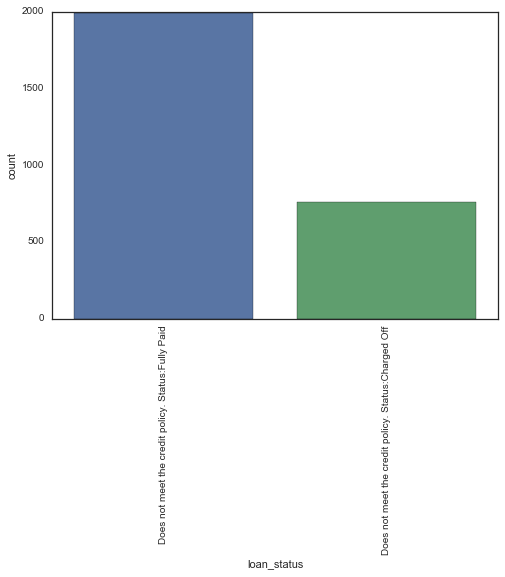

Fully Paid                                             207723
Charged Off                                             45248
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64


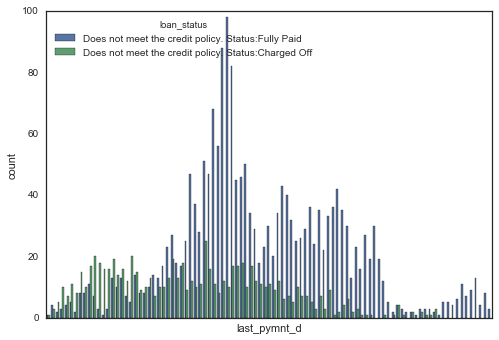

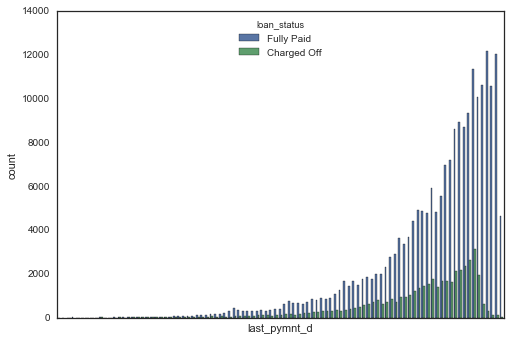

0.0    255720
Name: out_prncp, dtype: int64

In [20]:
sns.countplot(closed_loans[closed_loans['next_pymnt_d'].notnull()]['loan_status'])
plt.xticks(rotation=90)
plt.savefig('../figures/last_payment_day.jpg', bbox_inches='tight')
plt.show()
print(closed_loans['loan_status'].value_counts())
new_loans = ['Fully Paid', 'Charged Off']
sns.countplot(data=closed_loans[~closed_loans['loan_status'].isin(new_loans)], x='last_pymnt_d', hue='loan_status')
plt.xticks([])
plt.savefig('../figures/last_payment_day_old.jpg')
plt.show()
sns.countplot(data=closed_loans[closed_loans['loan_status'].isin(new_loans)], x='last_pymnt_d', hue='loan_status')
plt.xticks([])
plt.savefig('../figures/last_payment_day_new.jpg')
plt.show()
closed_loans['out_prncp'].value_counts()

## something weird with policy 2?
http://www.lendacademy.com/forum/index.php?topic=2427.msg20813#msg20813
Only policy 1 loans in this case, so no problem. 

In [21]:
closed_loans['policy_code'].value_counts()

1.0    255720
Name: policy_code, dtype: int64